In [63]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
train = pd.read_csv('../data/train_mod.csv')
test = pd.read_csv('../data/test_mod.csv')

## Sin sampleo

In [65]:
train.set_index('id')

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,income_loan_ratio,age_group,emp_length_group,age_income_ratio,emp_age_ratio,age_loan_ratio
id,,,,,,,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,0,14,0,5.833333,adult,junior,0.001057,0.000000,0.006167
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,0,2,0,14.000000,young-adult,semi-senior,0.000393,0.272727,0.005500
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,0,10,0,4.800000,young-adult,semi-senior,0.001007,0.275862,0.004833
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,0,5,0,5.833333,young-adult,senior,0.000429,0.466667,0.002500
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,0,3,0,10.000000,young-adult,junior,0.000367,0.090909,0.003667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,1,10,0,4.800000,adult,junior,0.000283,0.147059,0.001360
58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,0,8,1,2.880000,young-adult,junior,0.000972,0.000000,0.002800
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,0,2,1,6.470588,young-adult,semi-senior,0.000523,0.304348,0.003382


In [66]:
test_id = test['id']

In [67]:
X = train.drop(['loan_status'], axis=1)
y = train['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

vars_num = X_train.select_dtypes(include=['float64', 'int64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, vars_num),
])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

In [68]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94     10045
           1       0.70      0.38      0.49      1683

    accuracy                           0.89     11728
   macro avg       0.80      0.67      0.71     11728
weighted avg       0.87      0.89      0.87     11728

0.8874488403819918


In [69]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1_score_smote = f1_score(y_val, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score_smote)

Accuracy: 0.8874488403819918
Precision: 0.8740139501408759
Recall: 0.8874488403819918
F1 Score: 0.872578023563301


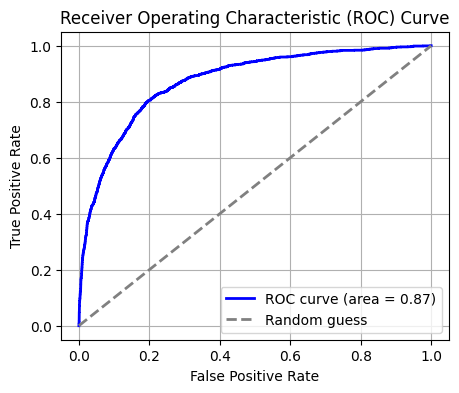

In [70]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


<Figure size 500x400 with 0 Axes>

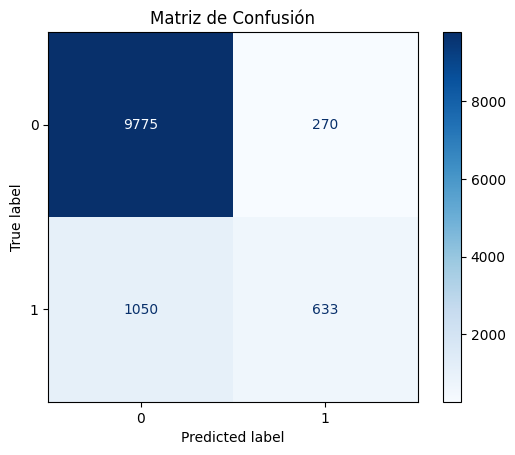

In [71]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

## Undersampling

In [72]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 40243, 1: 6666})
Resample dataset shape Counter({0: 6666, 1: 6666})


In [73]:
model.fit(x_rus, y_rus)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     10045
           1       0.39      0.82      0.53      1683

    accuracy                           0.79     11728
   macro avg       0.68      0.80      0.70     11728
weighted avg       0.88      0.79      0.82     11728

0.7887960436562074


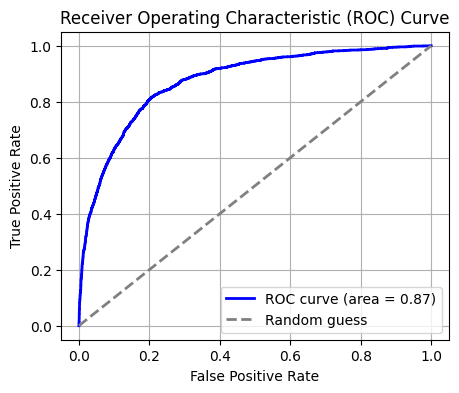

In [74]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

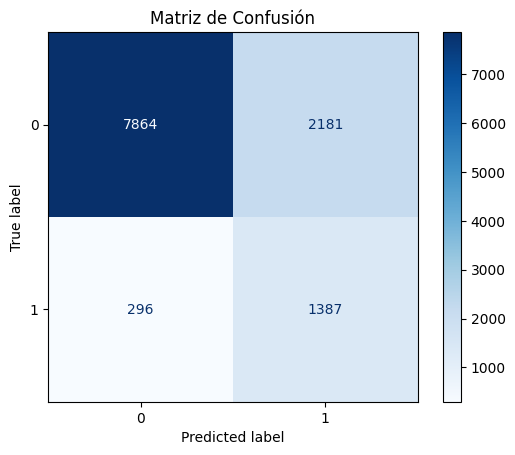

In [75]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

# Random Over Sampling

In [76]:
from imblearn.over_sampling import RandomOverSampler

smote = RandomOverSampler()
x_ros, y_ros = smote.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

original dataset shape: Counter({0: 40243, 1: 6666})
Resample dataset shape Counter({0: 40243, 1: 40243})


In [77]:
model.fit(x_ros, y_ros)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87     10045
           1       0.39      0.82      0.53      1683

    accuracy                           0.79     11728
   macro avg       0.68      0.80      0.70     11728
weighted avg       0.88      0.79      0.82     11728

0.7906718963165075


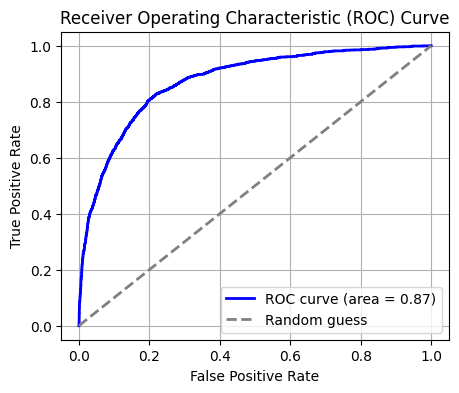

In [78]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

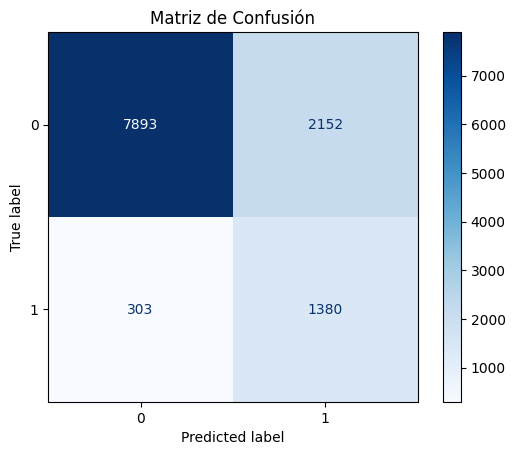

In [79]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

# SMOTE

In [80]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 40243, 1: 6666})
Resample dataset shape Counter({0: 40243, 1: 40243})


In [81]:
model.fit(x_smote, y_smote)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87     10045
           1       0.39      0.82      0.53      1683

    accuracy                           0.79     11728
   macro avg       0.68      0.80      0.70     11728
weighted avg       0.88      0.79      0.82     11728

0.791268758526603


In [82]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1_score_smote = f1_score(y_val, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score_smote)

Accuracy: 0.791268758526603
Precision: 0.8808290249163323
Recall: 0.791268758526603
F1 Score: 0.8176198839190142


# Comparativa

In [83]:
model.fit(X_train, y_train)
predict_y = model.predict(X_val)

print('ROC-AUC score DF Original:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_rus, y_rus)
predict_y = model.predict(X_val)
print('ROC-AUC score Under-sampling:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_ros, y_ros)
predict_y = model.predict(X_val)
print('ROC-AUC score Over-sampling:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_smote, y_smote)
predict_y = model.predict(X_val)
print('ROC-AUC score SMOTE:',round(roc_auc_score(y_val, predict_y),2))

ROC-AUC score DF Original: 0.67
ROC-AUC score Under-sampling: 0.8
ROC-AUC score Over-sampling: 0.8
ROC-AUC score SMOTE: 0.8


In [84]:
model.fit(X_train, y_train)
predict_y = model.predict_proba(X_val)[:, 1]
print('ROC-AUC score DF Original:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_rus, y_rus)
predict_y = model.predict_proba(X_val)[:, 1]
print('ROC-AUC score Under-sampling:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_ros, y_ros)
predict_y = model.predict_proba(X_val)[:, 1]
print('ROC-AUC score Over-sampling:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_smote, y_smote)
predict_y = model.predict_proba(X_val)[:, 1]
print('ROC-AUC score SMOTE:',round(roc_auc_score(y_val, predict_y),2))

ROC-AUC score DF Original: 0.87
ROC-AUC score Under-sampling: 0.87
ROC-AUC score Over-sampling: 0.87
ROC-AUC score SMOTE: 0.87


#### Despues del feature engineering, el modelo no parece haber mejorado mucho (apenas).

### Guardar resultados de test para subir a kaggle

In [85]:
# Transformaciones
test = preprocessor.fit_transform(test)

In [86]:
y_pred_prob = model.predict_proba(test)[:, 1]

In [87]:
y_pred

array([0, 0, 1, ..., 0, 0, 1])

In [88]:
predictions = pd.DataFrame(y_pred_prob)

In [89]:
predictions = predictions.reset_index().rename(columns={
    'index':'id',
    0:'loan_status'
})

In [90]:
predictions['id'] = test_id

In [91]:
predictions.head()

,id,loan_status
0,58645,0.956671
1,58646,0.211625
2,58647,0.876421
3,58648,0.164899
4,58649,0.601096


In [92]:
predictions.to_csv('baseline_predictions_features_prob.csv', index=False)